# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [65]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

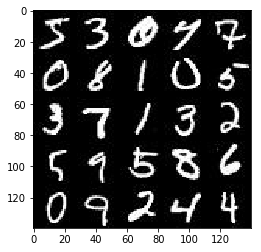

In [66]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

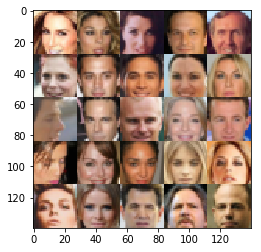

In [67]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [69]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [70]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [71]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train:
        reuse = False
    else:
        reuse = True
    alpha = 0.2
    with tf.variable_scope("generator", reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional\
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tf_vars = tf.trainable_variables()
    d_vars = [ele for ele in tf_vars if ele.name.startswith('discriminator')]
    g_vars = [ele for ele in tf_vars if ele.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_op, g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver() 
    if data_image_mode == 'RGB':
        image_channel = 3
    elif data_image_mode == 'L':
        image_channel = 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channel)
    d_op, g_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_batch = 25
    show_batch = 100
    steps = 0
    losses = []
    samples = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_op, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_op, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_batch == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_batch == 0:
                    gen_samples = sess.run(
                                   generator(input_z, image_channel, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 10, input_z, image_channel, data_image_mode)
#         saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.7515... Generator Loss: 3.0970


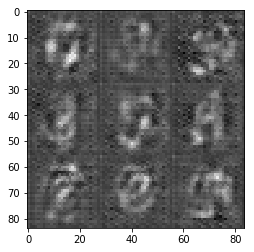

Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 1.4602


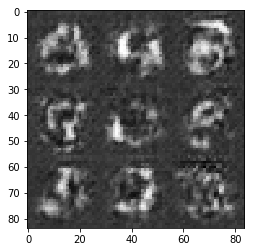

Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 1.6819
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 2.0725


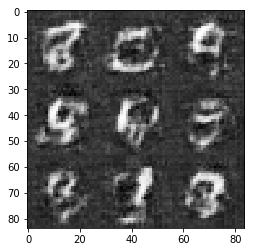

Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.5852
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 1.4232


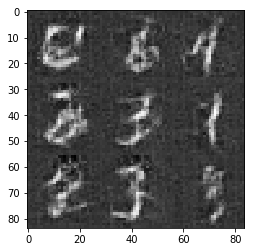

Epoch 1/2... Discriminator Loss: 2.0207... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.7025
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 2.8709... Generator Loss: 3.8679


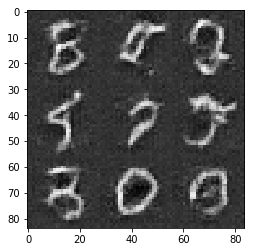

Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 2.7739... Generator Loss: 3.7123
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.4238
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.5435


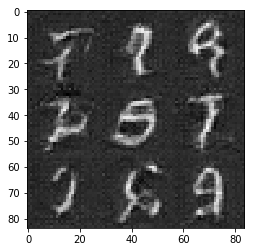

Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 2.5375
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.4037


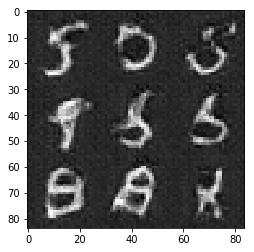

Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.2490
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.7532
Epoch 2/2... Discriminator Loss: 1.8138... Generator Loss: 1.4373


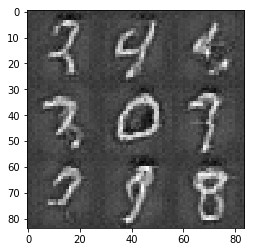

Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.5721
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.6993
Epoch 2/2... Discriminator Loss: 1.8444... Generator Loss: 2.5586
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 0.8315


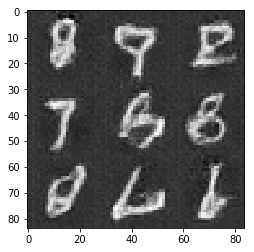

Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 1.7841
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 2.9538
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.0986


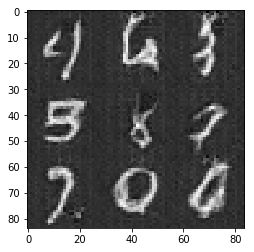

Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 2.5478
Epoch 2/2... Discriminator Loss: 1.7604... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.9018


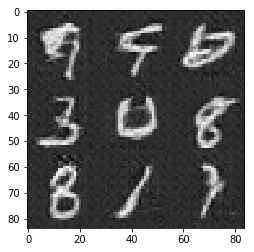

Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 2.3457
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 2.4794
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 0.4760... Generator Loss: 2.9810


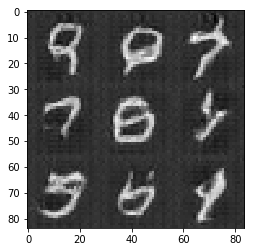

In [76]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/5... Discriminator Loss: 1.0049... Generator Loss: 0.9263
Epoch 1/5... Discriminator Loss: 2.0462... Generator Loss: 0.2095
Epoch 1/5... Discriminator Loss: 1.0726... Generator Loss: 3.3766
Epoch 1/5... Discriminator Loss: 0.7027... Generator Loss: 1.6140


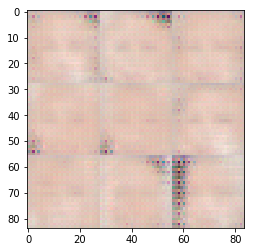

Epoch 1/5... Discriminator Loss: 1.4038... Generator Loss: 2.8950
Epoch 1/5... Discriminator Loss: 2.5970... Generator Loss: 2.5428
Epoch 1/5... Discriminator Loss: 1.4374... Generator Loss: 1.7534
Epoch 1/5... Discriminator Loss: 0.8769... Generator Loss: 1.3946


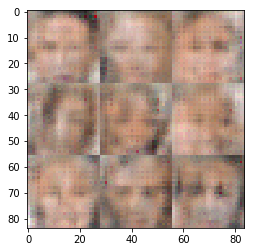

Epoch 1/5... Discriminator Loss: 1.0006... Generator Loss: 1.4914
Epoch 1/5... Discriminator Loss: 1.6460... Generator Loss: 0.3924
Epoch 1/5... Discriminator Loss: 1.0997... Generator Loss: 0.8979
Epoch 1/5... Discriminator Loss: 1.2210... Generator Loss: 0.8048


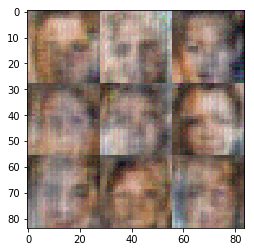

Epoch 1/5... Discriminator Loss: 1.4839... Generator Loss: 0.7190
Epoch 1/5... Discriminator Loss: 1.2709... Generator Loss: 1.4130
Epoch 1/5... Discriminator Loss: 1.9123... Generator Loss: 1.4288
Epoch 1/5... Discriminator Loss: 1.2633... Generator Loss: 0.9666


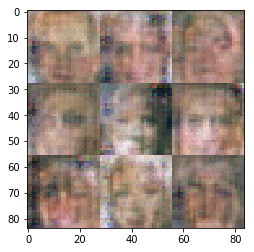

Epoch 1/5... Discriminator Loss: 1.6404... Generator Loss: 1.6430
Epoch 1/5... Discriminator Loss: 0.9558... Generator Loss: 1.1688
Epoch 1/5... Discriminator Loss: 0.9106... Generator Loss: 1.9294
Epoch 1/5... Discriminator Loss: 1.3794... Generator Loss: 0.6827


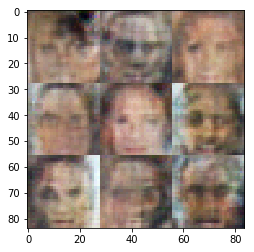

Epoch 1/5... Discriminator Loss: 1.2826... Generator Loss: 1.8613
Epoch 1/5... Discriminator Loss: 1.3234... Generator Loss: 0.5878
Epoch 1/5... Discriminator Loss: 1.9899... Generator Loss: 1.6194
Epoch 1/5... Discriminator Loss: 1.5854... Generator Loss: 0.4050


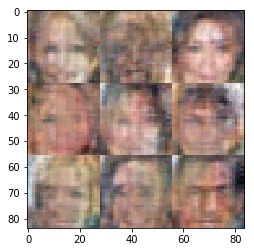

Epoch 1/5... Discriminator Loss: 2.2012... Generator Loss: 1.5208
Epoch 1/5... Discriminator Loss: 0.9324... Generator Loss: 1.8969
Epoch 1/5... Discriminator Loss: 2.2939... Generator Loss: 0.2031
Epoch 1/5... Discriminator Loss: 1.5231... Generator Loss: 0.5817


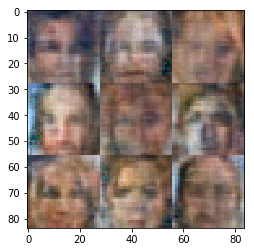

Epoch 1/5... Discriminator Loss: 1.9170... Generator Loss: 1.8607
Epoch 1/5... Discriminator Loss: 1.7946... Generator Loss: 0.3073
Epoch 1/5... Discriminator Loss: 1.1450... Generator Loss: 1.6201
Epoch 1/5... Discriminator Loss: 1.3223... Generator Loss: 1.0028


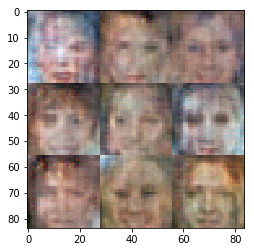

Epoch 1/5... Discriminator Loss: 1.2626... Generator Loss: 0.8608
Epoch 1/5... Discriminator Loss: 1.3126... Generator Loss: 1.2336
Epoch 1/5... Discriminator Loss: 1.4275... Generator Loss: 1.1579
Epoch 1/5... Discriminator Loss: 1.1442... Generator Loss: 1.0775


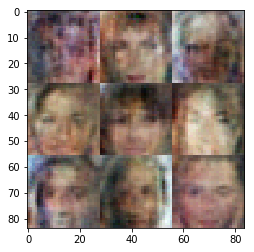

Epoch 1/5... Discriminator Loss: 1.3387... Generator Loss: 0.7548
Epoch 1/5... Discriminator Loss: 1.5166... Generator Loss: 1.4359
Epoch 1/5... Discriminator Loss: 1.4064... Generator Loss: 0.7278
Epoch 1/5... Discriminator Loss: 1.9096... Generator Loss: 1.4158


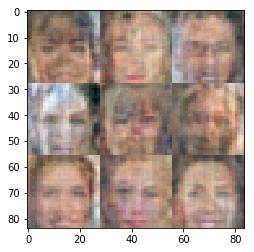

Epoch 1/5... Discriminator Loss: 1.4075... Generator Loss: 0.6478
Epoch 1/5... Discriminator Loss: 1.7143... Generator Loss: 1.2582
Epoch 1/5... Discriminator Loss: 0.8090... Generator Loss: 1.3164
Epoch 1/5... Discriminator Loss: 1.1177... Generator Loss: 1.0455


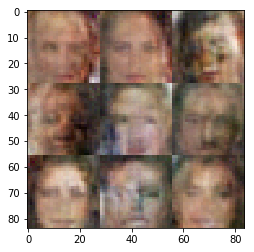

Epoch 1/5... Discriminator Loss: 1.3166... Generator Loss: 0.6908
Epoch 1/5... Discriminator Loss: 1.2156... Generator Loss: 0.6972
Epoch 1/5... Discriminator Loss: 0.9755... Generator Loss: 2.1368
Epoch 1/5... Discriminator Loss: 1.4769... Generator Loss: 0.5633


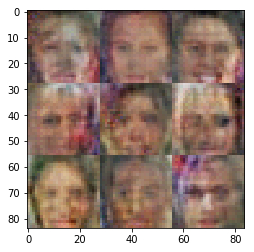

Epoch 1/5... Discriminator Loss: 1.3922... Generator Loss: 0.7577
Epoch 1/5... Discriminator Loss: 1.4510... Generator Loss: 0.6938
Epoch 1/5... Discriminator Loss: 1.5313... Generator Loss: 1.0297
Epoch 1/5... Discriminator Loss: 1.5692... Generator Loss: 1.3832


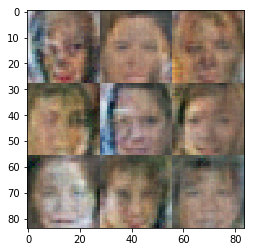

Epoch 1/5... Discriminator Loss: 1.1290... Generator Loss: 1.0809
Epoch 1/5... Discriminator Loss: 1.1764... Generator Loss: 0.8128
Epoch 1/5... Discriminator Loss: 3.1977... Generator Loss: 1.7886
Epoch 1/5... Discriminator Loss: 1.3681... Generator Loss: 0.8234


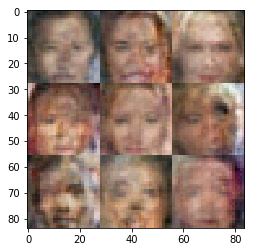

Epoch 1/5... Discriminator Loss: 1.3662... Generator Loss: 0.8024
Epoch 1/5... Discriminator Loss: 1.4207... Generator Loss: 0.6358
Epoch 1/5... Discriminator Loss: 1.3773... Generator Loss: 0.7848
Epoch 1/5... Discriminator Loss: 1.3710... Generator Loss: 0.7646


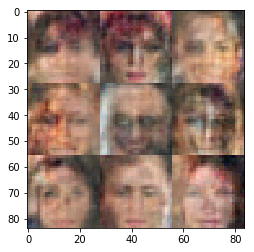

Epoch 1/5... Discriminator Loss: 1.3998... Generator Loss: 0.6966
Epoch 1/5... Discriminator Loss: 1.3788... Generator Loss: 0.9060
Epoch 1/5... Discriminator Loss: 1.3662... Generator Loss: 0.6816
Epoch 1/5... Discriminator Loss: 1.2326... Generator Loss: 0.8204


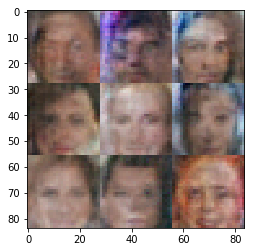

Epoch 1/5... Discriminator Loss: 1.4339... Generator Loss: 0.9342
Epoch 1/5... Discriminator Loss: 1.6826... Generator Loss: 0.6192
Epoch 1/5... Discriminator Loss: 1.3139... Generator Loss: 1.0673
Epoch 1/5... Discriminator Loss: 1.3845... Generator Loss: 0.7521


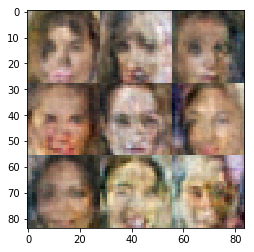

Epoch 1/5... Discriminator Loss: 1.3102... Generator Loss: 0.9838
Epoch 1/5... Discriminator Loss: 1.4073... Generator Loss: 0.7912
Epoch 1/5... Discriminator Loss: 1.4203... Generator Loss: 0.7316
Epoch 1/5... Discriminator Loss: 1.5041... Generator Loss: 0.4982


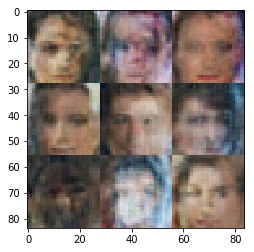

Epoch 1/5... Discriminator Loss: 1.5537... Generator Loss: 1.1352
Epoch 1/5... Discriminator Loss: 1.2032... Generator Loss: 0.9583
Epoch 1/5... Discriminator Loss: 1.3719... Generator Loss: 1.2224
Epoch 1/5... Discriminator Loss: 1.2664... Generator Loss: 0.8241


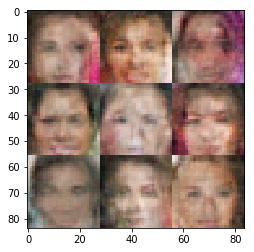

Epoch 1/5... Discriminator Loss: 1.8295... Generator Loss: 1.3777
Epoch 1/5... Discriminator Loss: 1.3673... Generator Loss: 0.7254
Epoch 1/5... Discriminator Loss: 1.3276... Generator Loss: 0.8218
Epoch 1/5... Discriminator Loss: 1.4398... Generator Loss: 0.7212


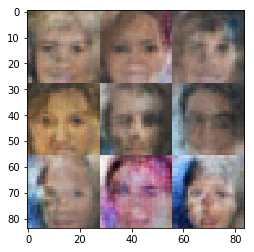

Epoch 1/5... Discriminator Loss: 1.3688... Generator Loss: 0.6734
Epoch 2/5... Discriminator Loss: 1.3324... Generator Loss: 0.8574
Epoch 2/5... Discriminator Loss: 1.3910... Generator Loss: 0.6886
Epoch 2/5... Discriminator Loss: 1.4874... Generator Loss: 0.5310


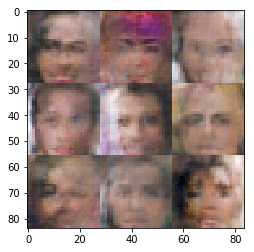

Epoch 2/5... Discriminator Loss: 1.3642... Generator Loss: 0.8584
Epoch 2/5... Discriminator Loss: 1.3648... Generator Loss: 0.9111
Epoch 2/5... Discriminator Loss: 1.3244... Generator Loss: 0.7448
Epoch 2/5... Discriminator Loss: 1.3348... Generator Loss: 1.0830


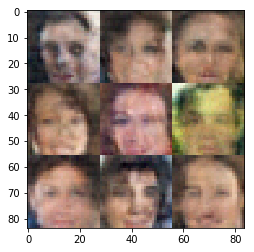

Epoch 2/5... Discriminator Loss: 1.3199... Generator Loss: 0.7496
Epoch 2/5... Discriminator Loss: 1.3958... Generator Loss: 0.8966
Epoch 2/5... Discriminator Loss: 1.3479... Generator Loss: 0.8421
Epoch 2/5... Discriminator Loss: 1.3931... Generator Loss: 0.6726


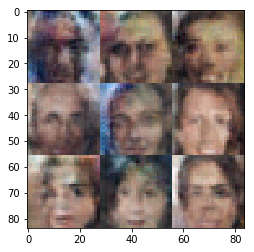

Epoch 2/5... Discriminator Loss: 1.8538... Generator Loss: 0.8608
Epoch 2/5... Discriminator Loss: 1.3300... Generator Loss: 0.8667
Epoch 2/5... Discriminator Loss: 1.3888... Generator Loss: 0.9020
Epoch 2/5... Discriminator Loss: 1.3507... Generator Loss: 0.8338


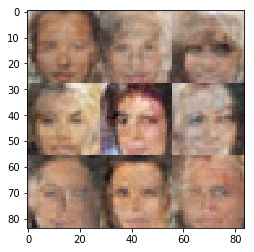

Epoch 2/5... Discriminator Loss: 1.3403... Generator Loss: 0.7761
Epoch 2/5... Discriminator Loss: 1.4265... Generator Loss: 1.1396
Epoch 2/5... Discriminator Loss: 1.3795... Generator Loss: 0.7003
Epoch 2/5... Discriminator Loss: 1.3937... Generator Loss: 0.7736


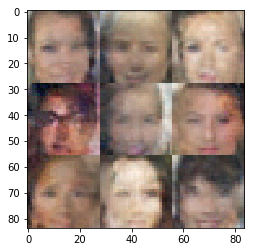

Epoch 2/5... Discriminator Loss: 1.3688... Generator Loss: 0.8958
Epoch 2/5... Discriminator Loss: 1.4095... Generator Loss: 0.8422
Epoch 2/5... Discriminator Loss: 1.4519... Generator Loss: 0.5359
Epoch 2/5... Discriminator Loss: 1.4052... Generator Loss: 0.7074


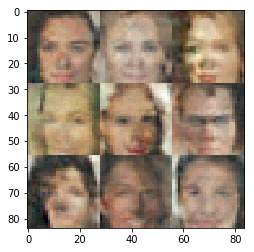

Epoch 2/5... Discriminator Loss: 1.3667... Generator Loss: 0.9215
Epoch 2/5... Discriminator Loss: 1.5063... Generator Loss: 1.4435
Epoch 2/5... Discriminator Loss: 1.3981... Generator Loss: 0.6304
Epoch 2/5... Discriminator Loss: 1.3589... Generator Loss: 0.8942


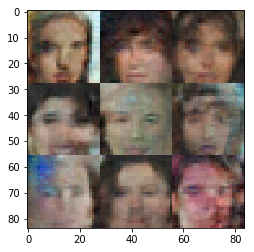

Epoch 2/5... Discriminator Loss: 1.3964... Generator Loss: 0.7420
Epoch 2/5... Discriminator Loss: 1.4217... Generator Loss: 0.7476
Epoch 2/5... Discriminator Loss: 1.4290... Generator Loss: 0.5811
Epoch 2/5... Discriminator Loss: 1.3976... Generator Loss: 0.7229


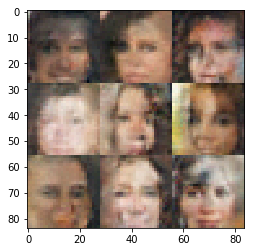

Epoch 2/5... Discriminator Loss: 1.4097... Generator Loss: 0.7677
Epoch 2/5... Discriminator Loss: 1.3877... Generator Loss: 0.7197
Epoch 2/5... Discriminator Loss: 1.3836... Generator Loss: 0.7385
Epoch 2/5... Discriminator Loss: 1.3456... Generator Loss: 0.8455


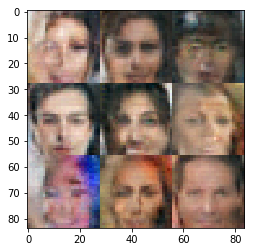

Epoch 2/5... Discriminator Loss: 1.3850... Generator Loss: 0.8355
Epoch 2/5... Discriminator Loss: 1.5229... Generator Loss: 0.5104
Epoch 2/5... Discriminator Loss: 1.3362... Generator Loss: 0.9085
Epoch 2/5... Discriminator Loss: 1.3811... Generator Loss: 0.8317


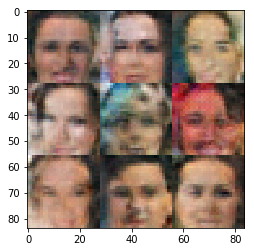

Epoch 2/5... Discriminator Loss: 1.3615... Generator Loss: 0.7922
Epoch 2/5... Discriminator Loss: 1.3604... Generator Loss: 0.7891
Epoch 2/5... Discriminator Loss: 1.4017... Generator Loss: 0.8358
Epoch 2/5... Discriminator Loss: 1.3564... Generator Loss: 0.7931


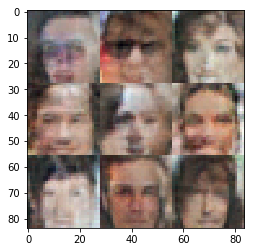

Epoch 2/5... Discriminator Loss: 1.4257... Generator Loss: 0.5802
Epoch 2/5... Discriminator Loss: 1.3968... Generator Loss: 0.8283
Epoch 2/5... Discriminator Loss: 1.4135... Generator Loss: 0.6824
Epoch 2/5... Discriminator Loss: 1.3511... Generator Loss: 0.8680


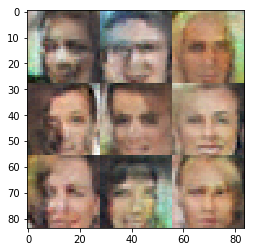

Epoch 2/5... Discriminator Loss: 1.3957... Generator Loss: 0.9032
Epoch 2/5... Discriminator Loss: 1.3945... Generator Loss: 0.7561
Epoch 2/5... Discriminator Loss: 1.4169... Generator Loss: 0.6192
Epoch 2/5... Discriminator Loss: 1.3731... Generator Loss: 0.8077


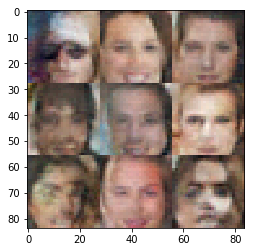

Epoch 2/5... Discriminator Loss: 1.3777... Generator Loss: 0.7692
Epoch 2/5... Discriminator Loss: 1.3365... Generator Loss: 0.8085
Epoch 2/5... Discriminator Loss: 1.3566... Generator Loss: 0.9004
Epoch 2/5... Discriminator Loss: 1.3924... Generator Loss: 0.7636


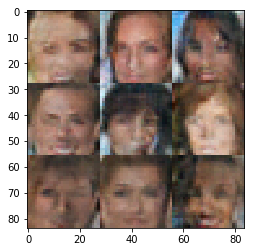

Epoch 2/5... Discriminator Loss: 1.3816... Generator Loss: 0.7521
Epoch 2/5... Discriminator Loss: 1.4047... Generator Loss: 0.7300
Epoch 2/5... Discriminator Loss: 1.3692... Generator Loss: 0.7180
Epoch 2/5... Discriminator Loss: 1.3928... Generator Loss: 0.6482


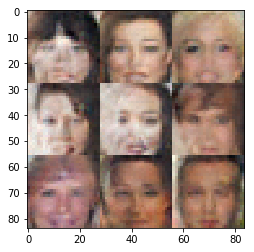

Epoch 2/5... Discriminator Loss: 1.3989... Generator Loss: 0.7677
Epoch 2/5... Discriminator Loss: 1.4210... Generator Loss: 0.7514
Epoch 2/5... Discriminator Loss: 1.3874... Generator Loss: 0.7299
Epoch 2/5... Discriminator Loss: 1.4062... Generator Loss: 0.8440


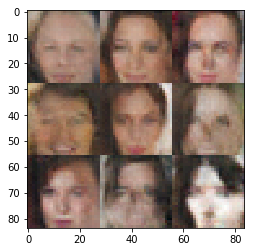

Epoch 2/5... Discriminator Loss: 1.3532... Generator Loss: 0.7747
Epoch 2/5... Discriminator Loss: 1.3570... Generator Loss: 0.7678
Epoch 2/5... Discriminator Loss: 1.4503... Generator Loss: 0.7995
Epoch 2/5... Discriminator Loss: 1.4016... Generator Loss: 0.7961


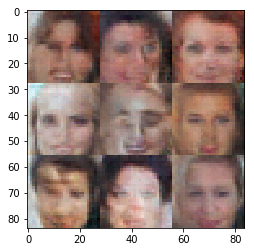

Epoch 2/5... Discriminator Loss: 1.4469... Generator Loss: 0.7282
Epoch 2/5... Discriminator Loss: 1.4023... Generator Loss: 0.8428
Epoch 2/5... Discriminator Loss: 1.3598... Generator Loss: 0.8081
Epoch 2/5... Discriminator Loss: 1.4293... Generator Loss: 0.8286


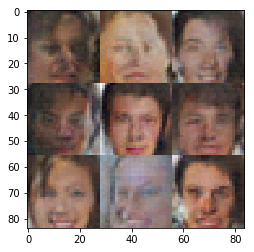

Epoch 2/5... Discriminator Loss: 1.3078... Generator Loss: 0.8757
Epoch 2/5... Discriminator Loss: 1.4334... Generator Loss: 0.5914
Epoch 2/5... Discriminator Loss: 1.3592... Generator Loss: 0.7645
Epoch 2/5... Discriminator Loss: 1.3555... Generator Loss: 0.7768


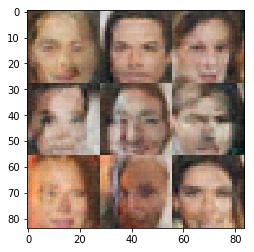

Epoch 2/5... Discriminator Loss: 1.3882... Generator Loss: 0.8511
Epoch 2/5... Discriminator Loss: 1.3899... Generator Loss: 0.6808
Epoch 2/5... Discriminator Loss: 1.4156... Generator Loss: 0.6744
Epoch 2/5... Discriminator Loss: 1.4125... Generator Loss: 0.7954


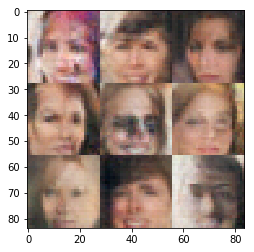

Epoch 2/5... Discriminator Loss: 1.3965... Generator Loss: 0.8623
Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.7232
Epoch 3/5... Discriminator Loss: 1.3833... Generator Loss: 0.7907
Epoch 3/5... Discriminator Loss: 1.4201... Generator Loss: 0.7197


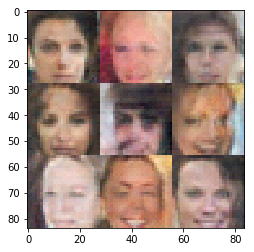

Epoch 3/5... Discriminator Loss: 1.3808... Generator Loss: 0.7165
Epoch 3/5... Discriminator Loss: 1.4168... Generator Loss: 0.8092
Epoch 3/5... Discriminator Loss: 1.3637... Generator Loss: 0.7963
Epoch 3/5... Discriminator Loss: 1.3760... Generator Loss: 0.7166


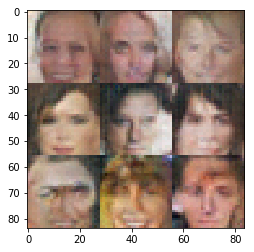

Epoch 3/5... Discriminator Loss: 1.5253... Generator Loss: 0.8881
Epoch 3/5... Discriminator Loss: 1.3780... Generator Loss: 0.7781
Epoch 3/5... Discriminator Loss: 1.3892... Generator Loss: 0.7732
Epoch 3/5... Discriminator Loss: 1.4283... Generator Loss: 0.7290


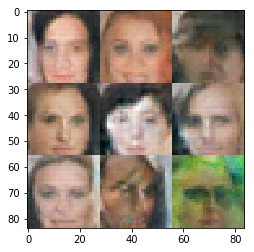

Epoch 3/5... Discriminator Loss: 1.4067... Generator Loss: 0.7909
Epoch 3/5... Discriminator Loss: 1.4172... Generator Loss: 0.7343
Epoch 3/5... Discriminator Loss: 1.3866... Generator Loss: 0.7689
Epoch 3/5... Discriminator Loss: 1.6177... Generator Loss: 0.7483


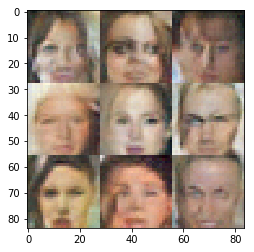

Epoch 3/5... Discriminator Loss: 1.4235... Generator Loss: 0.6923
Epoch 3/5... Discriminator Loss: 1.4066... Generator Loss: 0.7457
Epoch 3/5... Discriminator Loss: 1.3819... Generator Loss: 0.8097
Epoch 3/5... Discriminator Loss: 1.3686... Generator Loss: 0.7355


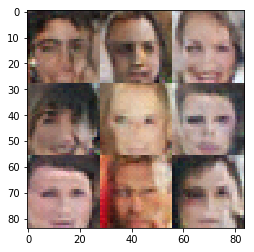

Epoch 3/5... Discriminator Loss: 1.3888... Generator Loss: 0.8483
Epoch 3/5... Discriminator Loss: 1.4013... Generator Loss: 0.8647
Epoch 3/5... Discriminator Loss: 1.3968... Generator Loss: 0.7544
Epoch 3/5... Discriminator Loss: 1.3472... Generator Loss: 0.7916


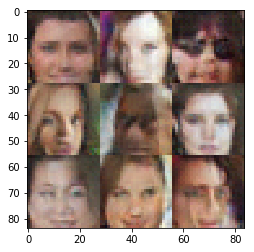

Epoch 3/5... Discriminator Loss: 1.4020... Generator Loss: 0.7166
Epoch 3/5... Discriminator Loss: 1.3848... Generator Loss: 1.0220
Epoch 3/5... Discriminator Loss: 1.3752... Generator Loss: 0.7661
Epoch 3/5... Discriminator Loss: 1.4128... Generator Loss: 0.7180


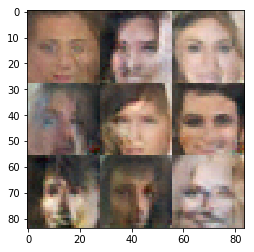

Epoch 3/5... Discriminator Loss: 1.3885... Generator Loss: 0.7525
Epoch 3/5... Discriminator Loss: 1.3540... Generator Loss: 0.8076
Epoch 3/5... Discriminator Loss: 1.3838... Generator Loss: 0.8172
Epoch 3/5... Discriminator Loss: 1.3843... Generator Loss: 0.7598


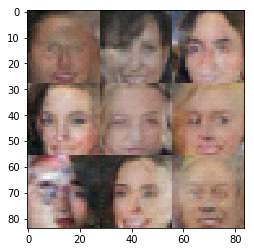

Epoch 3/5... Discriminator Loss: 1.3929... Generator Loss: 0.7321
Epoch 3/5... Discriminator Loss: 1.3637... Generator Loss: 0.7903
Epoch 3/5... Discriminator Loss: 1.3805... Generator Loss: 0.7388
Epoch 3/5... Discriminator Loss: 1.4033... Generator Loss: 0.9963


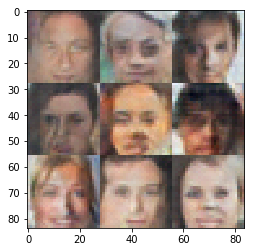

KeyboardInterrupt: 

In [77]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。